# Experiment 2
## Visual assesment of reconstructions

This experiments shows the visual behaviour of reconstructing images from the MNIST dataset using the following structural assumptions on the signal set:
- Sparsity in standard basis,
- Sparsity in single level 2D Haar wavelets and
- Generative model.

The specific choice of sparsity levels and generative model parameters were chosen empirically.

In [1]:
import numpy as np;
import numpy.linalg as linalg;

import matplotlib.pyplot as plt;
from matplotlib.pyplot import figure;

import pywt;

import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torch.optim as optim;

from torch.utils.data import DataLoader;
import torchvision;

import pickle;
import time;
import random;
import math;

from IPython.display import clear_output;
from PIL import Image;

import MNIST_utils as MNIST;
import MNIST_generative as generative;
import sparsity_utils as sparsity;
import general_utils as utils;

# Initialization

In [2]:
(train_data, test_data), (train_loader, test_loader) = MNIST.load_dataset();

noise = 0.1;
mspace_standard = np.array([300,500,700,1000,1500,2000,2500]);
mspace_haar = np.array([200,300,400,500,600,700,800]);
mspace_gen = np.array([10, 50, 100, 125, 150, 175, 200, 250, 300]);

sparsity_standard = 100;
sparsity_haar = 40;

# Standard basis experiment

In [3]:
data = [[() for i in range(len(mspace_standard))] for j in range(5)];

utils.reset_seeds();

for j in range(5):
    x = MNIST.getImageAsVector(test_loader, j);
    for i in range(len(mspace_standard)):
        m = mspace_standard[i];
        A, q = utils.generateMeasurements_Gaussian(x, m, noise);
        q = utils.quantize(q);
        y, accuracy = MNIST.reconstruct_BIP(A, q, x, lambda z : sparsity.HT(z, sparsity_standard),
                                      learning_param = 0.0005, iterations = 500);
        data[j][i] = (MNIST.VectorToImage(y), accuracy);
        print(j, m);
    clear_output(wait=True);

clear_output(wait=True);

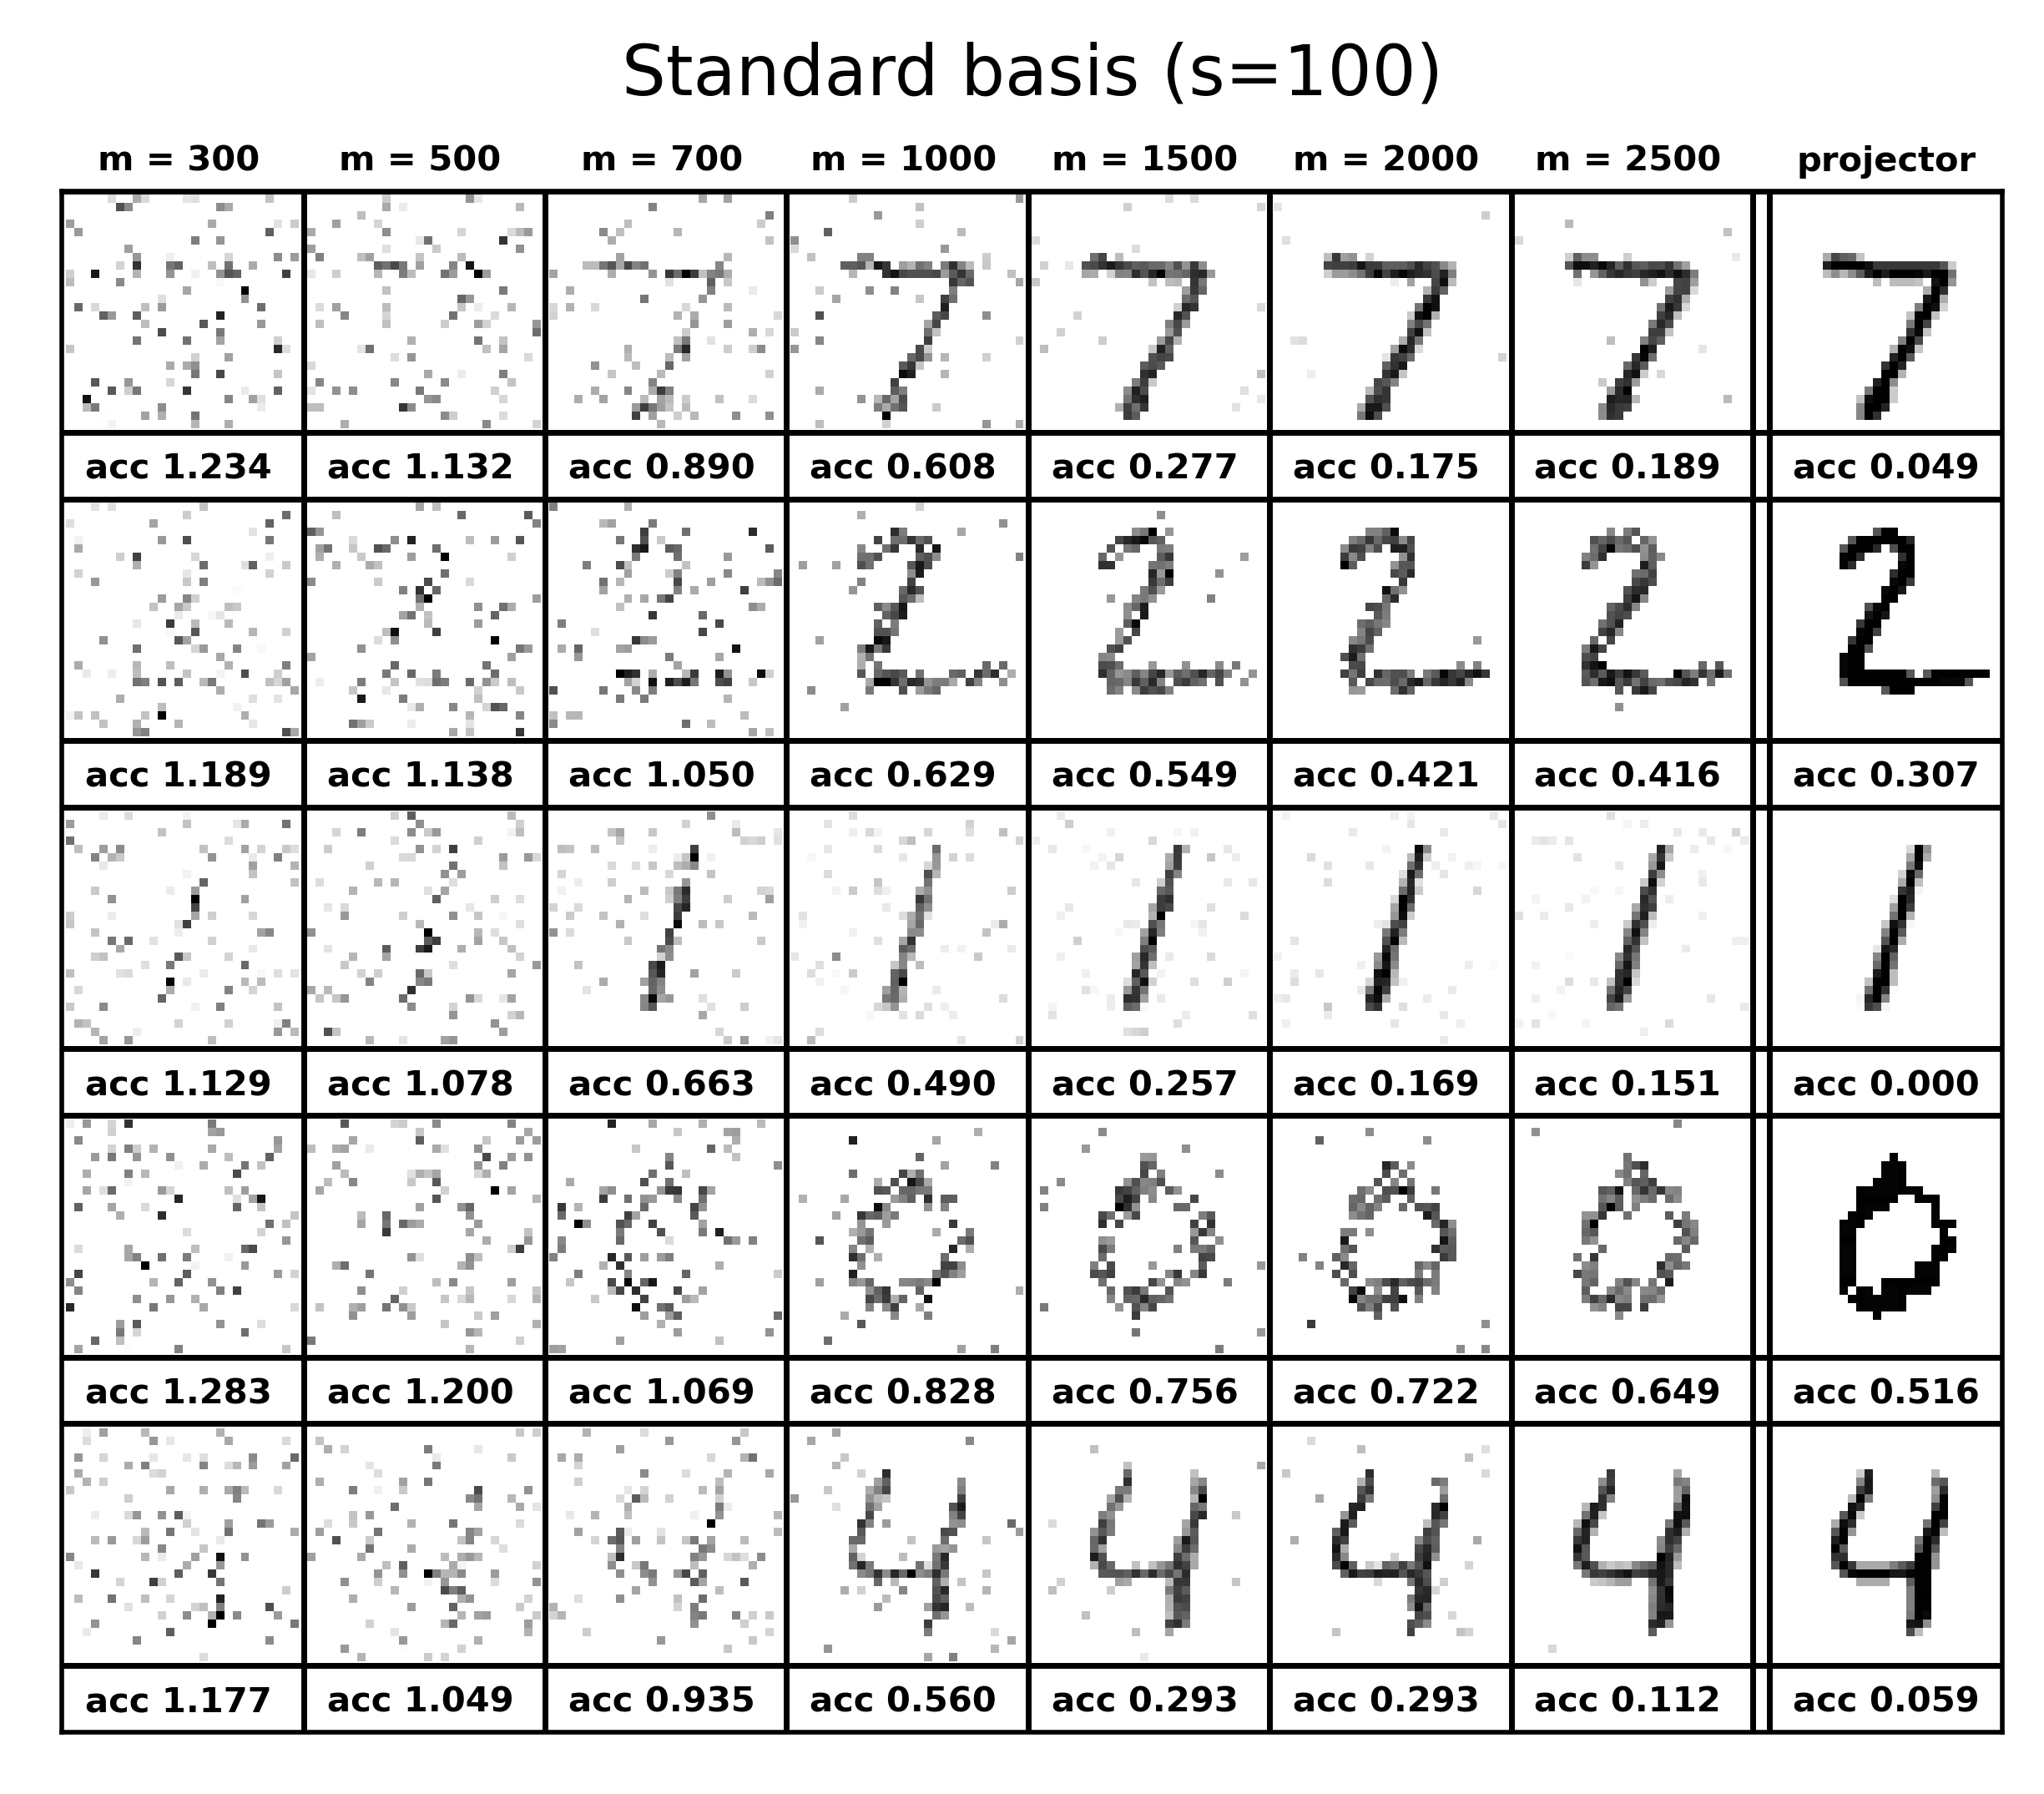

In [14]:
accheight = 8;

results = np.zeros((((28+accheight+1)*5) + 1,(len(mspace_standard)+1)*(28+1)+2));

for j in range(5):
    for i in range(len(mspace_standard)):
        index = i;
        image = data[j][index][0];
        image = np.abs(image);
        image = image/np.max(image);
        results[(28+accheight+1)*j + 1:(28+accheight+1)*j+28 + 1,(28+1)*i + 1:(28+1)*i+28 + 1] = MNIST.VectorToImage(image);
    best_img = MNIST.VectorToImage(sparsity.HT(MNIST.getImageAsVector(test_loader, j), sparsity_standard));
    results[(28+accheight+1)*j + 1:(28+accheight+1)*j+28 + 1,(28+1)*len(mspace_standard) + 1 + 2:(28+1)*len(mspace_standard)+28 + 1 + 2] = best_img;

figure(figsize=(6, 5), dpi=500)
    
plt.imshow(results, cmap='binary');
plt.xticks([]);
plt.yticks([]);
plt.ylim([((28+accheight+1)*5),0]);
plt.xlim([0, (len(mspace_standard)+1)*(28+1)-1 + 2]);
plt.vlines([i*(28+1) for i in range(1,(len(mspace_standard)+1))],0,((28+accheight+1)*5), colors='black', linewidth=1);
plt.vlines([(len(mspace_standard))*(28+1) + 2],0,((28+accheight+1)*5), colors='black', linewidth=1);
plt.hlines([i*(28+accheight+1) for i in range(5)],0,(len(mspace_standard)+1)*(28+1)-1 + 2, colors='black', linewidth=1);
plt.hlines([i*(28+accheight+1)-accheight for i in range(1,6)],0,(len(mspace_standard)+1)*(28+1)-1 + 2, colors='black', linewidth=1);

for i in range(len(mspace_standard)):
    plt.text((28+1)*i + 14, -2.5, "m = " + str(mspace_standard[i]), fontsize=6.0, fontweight="bold", ha="center");

plt.text((28+1)*len(mspace_standard) + 14 + 2, -2.5, "projector", fontsize=6.0, fontweight="bold", ha="center");

for j in range(5):
    for i in range(len(mspace_standard)):
        string = "acc {:.3f}".format(data[j][i][1]);
        plt.text((28+1)*i + 14, -2.5 + ((j+1)*(28+1+accheight)), string, fontsize=6.0, fontweight="bold", ha="center");
    best_img = MNIST.VectorToImage(sparsity.HT(MNIST.getImageAsVector(test_loader, j), sparsity_standard));
    best_val = linalg.norm(utils.normalize( MNIST.getImageAsVector(test_loader, j))-utils.normalize(MNIST.ImageToVector(best_img)));
    string = "acc {:.3f}".format(best_val);
    plt.text((28+1)*len(mspace_standard) + 14 + 2, -2.5 + ((j+1)*(28+1+accheight)), string, fontsize=6.0, fontweight="bold", ha="center");
        
plt.rcParams['axes.titley'] = 1.04;
plt.title("Standard basis (s=100)");
plt.savefig("results_images/images_standard.png", dpi=500);

# Wavelets experiment

In [15]:
data = [[() for i in range(len(mspace_haar))] for j in range(5)];#

utils.reset_seeds();
for j in range(5):
    x = MNIST.getImageAsVector(test_loader, j);
    for i in range(len(mspace_haar)):
        m = mspace_haar[i];
        A, q = utils.generateMeasurements_Gaussian(x, m, noise);
        q = utils.quantize(q);
        y, accuracy = MNIST.reconstruct_BIP(A, q, x,
                                      lambda z : sparsity.HT_transform(z, sparsity_haar, sparsity.haar2d, sparsity.inverse_haar2d),
                                      learning_param = 0.0005, iterations = 500);
        data[j][i] = (MNIST.VectorToImage(y), accuracy);
        print(j, m);
    clear_output(wait=True);

clear_output(wait=True);

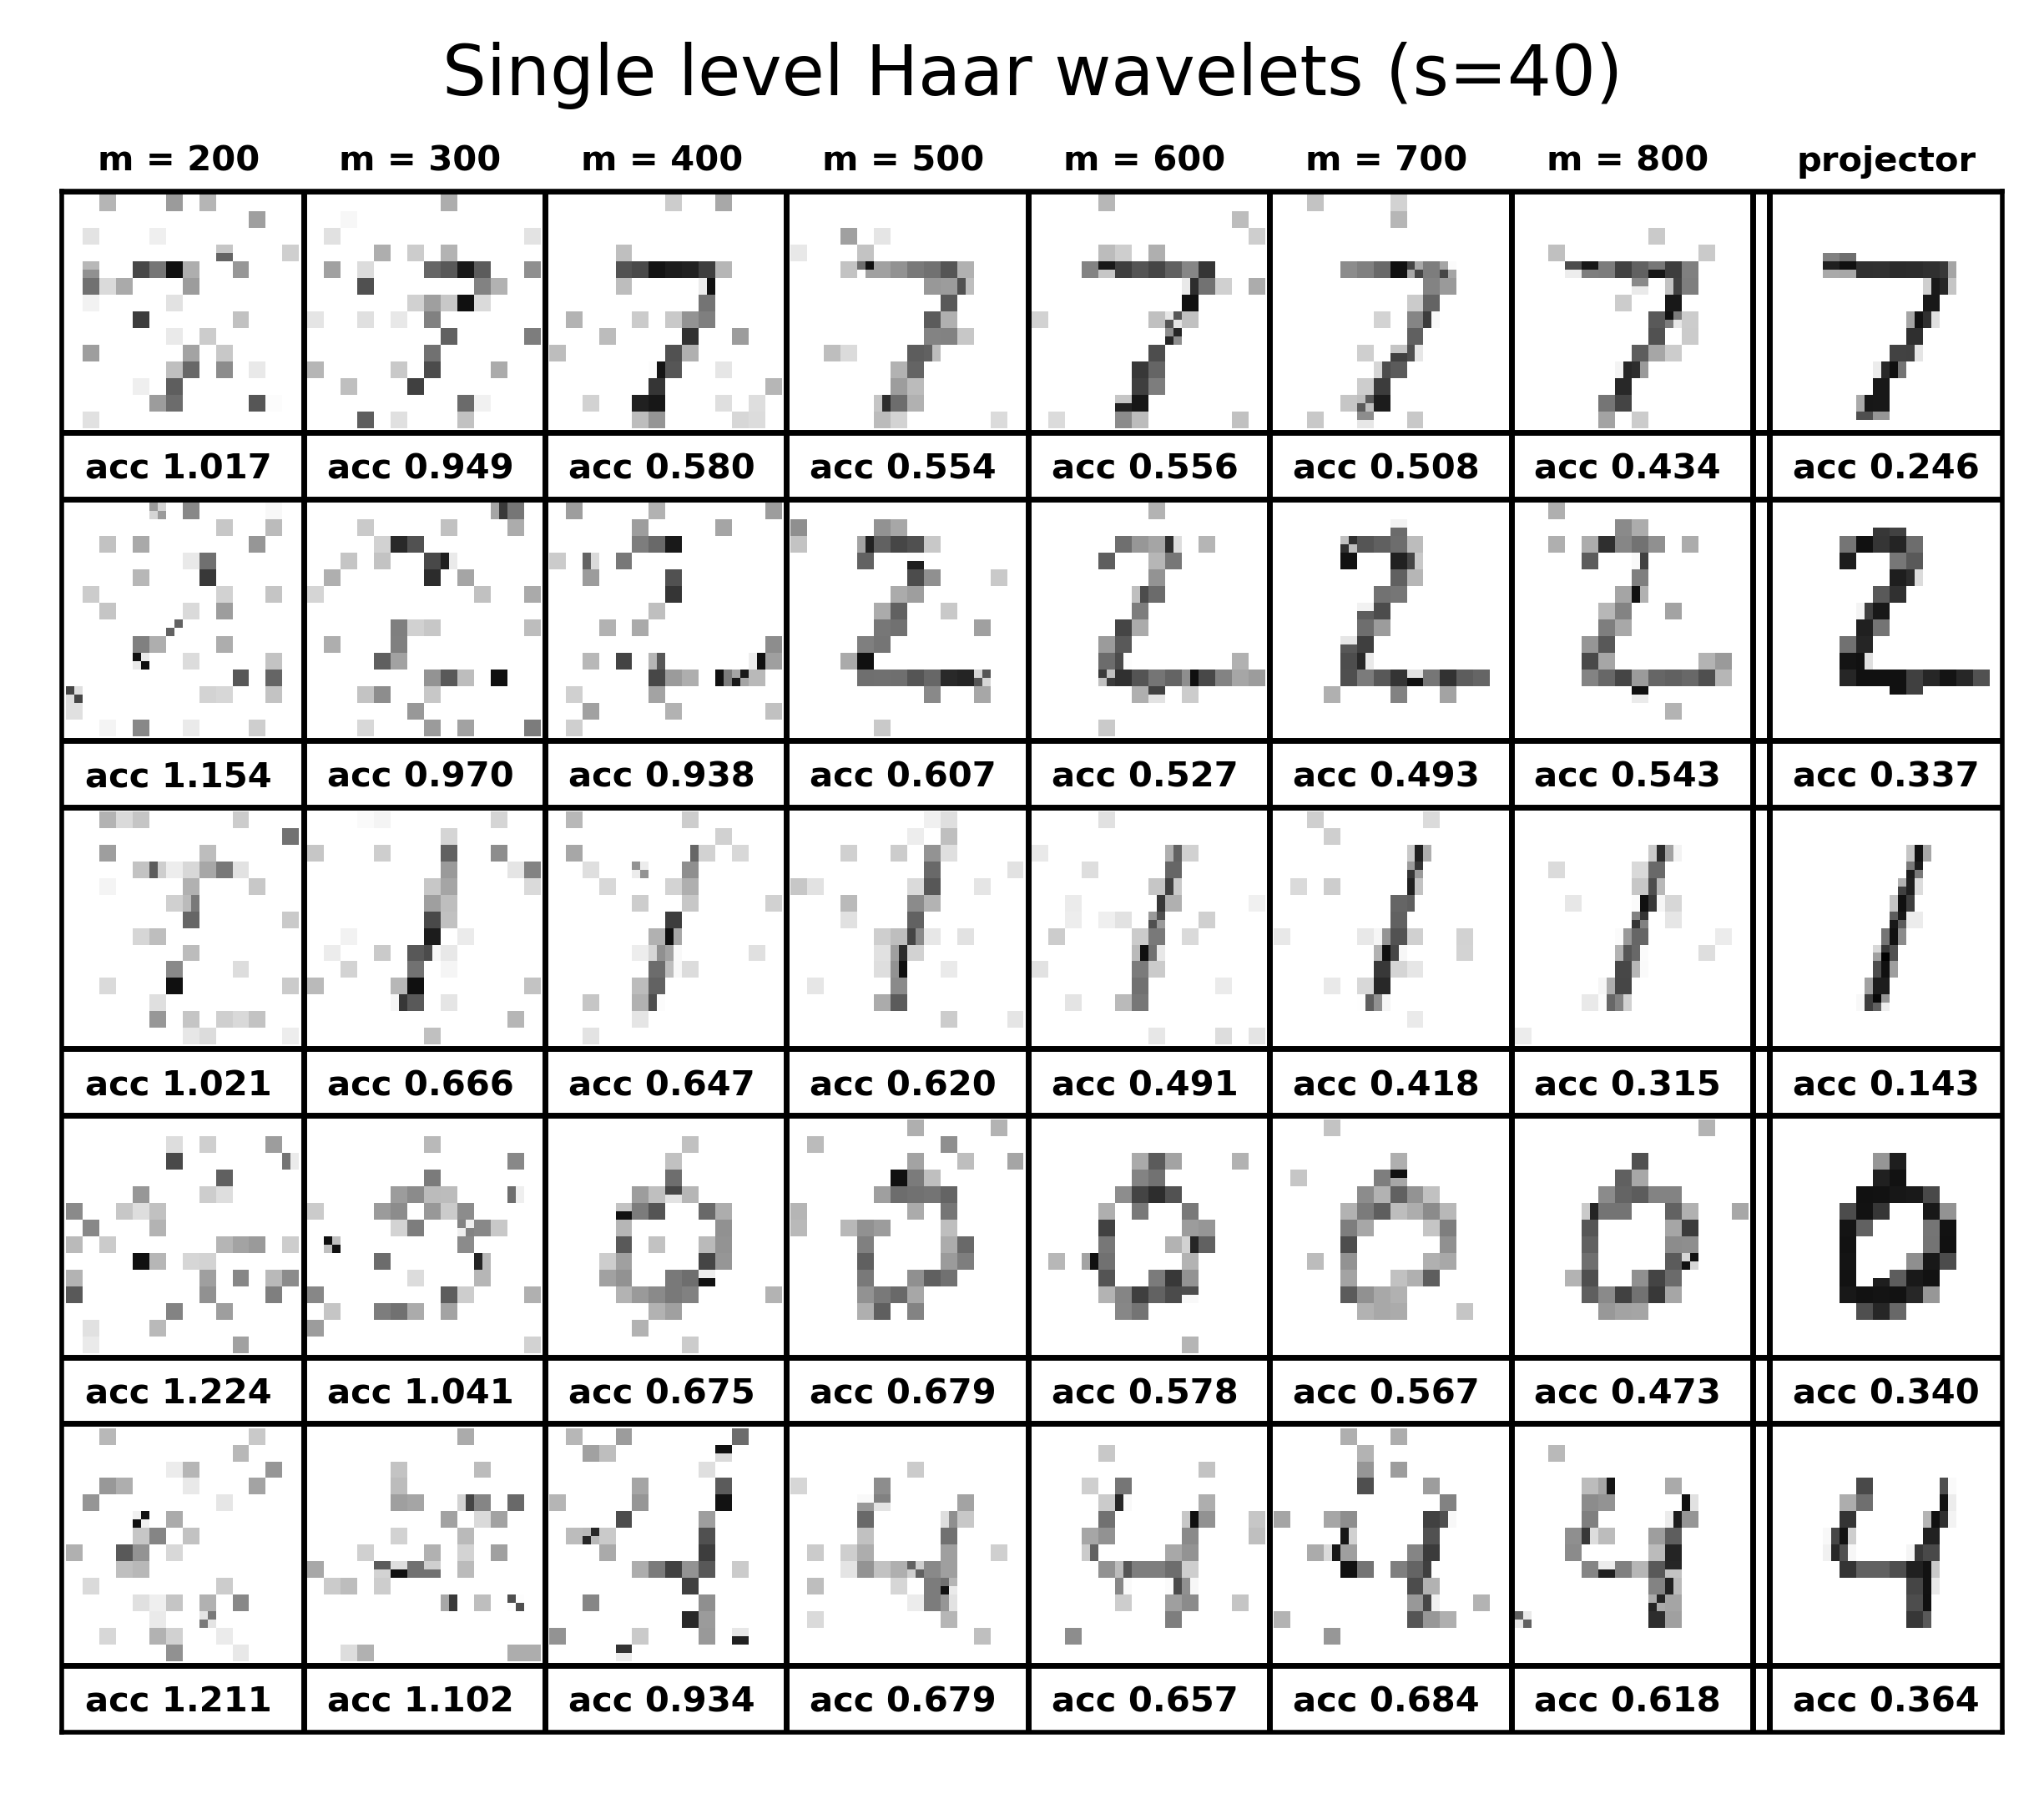

In [19]:
accheight = 8;

results = np.zeros((((28+accheight+1)*5) + 1,(len(mspace_haar)+1)*(28+1)+2));

for j in range(5):
    for i in range(len(mspace_haar)):
        index = i;
        image = data[j][index][0];
        image = np.abs(image);
        image = image/np.max(image);
        results[(28+accheight+1)*j + 1:(28+accheight+1)*j+28 + 1,(28+1)*i + 1:(28+1)*i+28 + 1] = MNIST.VectorToImage(image);
    best_img = np.abs(MNIST.VectorToImage(sparsity.HT_transform(MNIST.getImageAsVector(test_loader, j), sparsity_haar, sparsity.haar2d, sparsity.inverse_haar2d)));
    results[(28+accheight+1)*j + 1:(28+accheight+1)*j+28 + 1,(28+1)*len(mspace_haar) + 1 + 2:(28+1)*len(mspace_haar)+28 + 1 + 2] = best_img;

figure(figsize=(6, 5), dpi=500)
    
plt.imshow(results, cmap='binary');
plt.xticks([]);
plt.yticks([]);
plt.ylim([((28+accheight+1)*5),0]);
plt.xlim([0, (len(mspace_haar)+1)*(28+1)-1 + 2]);
plt.vlines([i*(28+1) for i in range(1,(len(mspace_haar)+1))],0,((28+accheight+1)*5), colors='black', linewidth=1);
plt.vlines([(len(mspace_haar))*(28+1) + 2],0,((28+accheight+1)*5), colors='black', linewidth=1);
plt.hlines([i*(28+accheight+1) for i in range(5)],0,(len(mspace_haar)+1)*(28+1)-1 + 2, colors='black', linewidth=1);
plt.hlines([i*(28+accheight+1)-accheight for i in range(1,6)],0,(len(mspace_haar)+1)*(28+1)-1 + 2, colors='black', linewidth=1);

for i in range(len(mspace_haar)):
    plt.text((28+1)*i + 14, -2.5, "m = " + str(mspace_haar[i]), fontsize=6.0, fontweight="bold", ha="center");

plt.text((28+1)*len(mspace_haar) + 14 + 2, -2.5, "projector", fontsize=6.0, fontweight="bold", ha="center");

for j in range(5):
    for i in range(len(mspace_haar)):
        string = "acc {:.3f}".format(data[j][i][1]);
        plt.text((28+1)*i + 14, -2.5 + ((j+1)*(28+1+accheight)), string, fontsize=6.0, fontweight="bold", ha="center");
    best_img = np.abs(MNIST.VectorToImage(sparsity.HT_transform(MNIST.getImageAsVector(test_loader, j), sparsity_haar, sparsity.haar2d, sparsity.inverse_haar2d)));
    best_val = linalg.norm(utils.normalize(MNIST.getImageAsVector(test_loader, j))-utils.normalize(MNIST.ImageToVector(best_img)));
    string = "acc {:.3f}".format(best_val);
    plt.text((28+1)*len(mspace_haar) + 14 + 2, -2.5 + ((j+1)*(28+1+accheight)), string, fontsize=6.0, fontweight="bold", ha="center");
        
plt.rcParams['axes.titley'] = 1.04;        
plt.title("Single level Haar wavelets (s=40)");
plt.savefig("results_images/images_haar.png", dpi=500);

# Generative model experiment

In [20]:
utils.reset_seeds();
_, autoEncoder = generative.createNetwork(3, 50);
generative.trainNetwork(autoEncoder, train_loader);

projector = lambda x : generative.project(x, autoEncoder , num_epochs = 50, learning_rate = 0.001);

C:\Users\jever\anaconda3\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	 Train_loss: 1.027420
Epoch: 2 	 Train_loss: 0.486251
Epoch: 3 	 Train_loss: 0.371241
Epoch: 4 	 Train_loss: 0.319043
Epoch: 5 	 Train_loss: 0.289701
Epoch: 6 	 Train_loss: 0.268666
Epoch: 7 	 Train_loss: 0.252897
Epoch: 8 	 Train_loss: 0.241851
Epoch: 9 	 Train_loss: 0.233260
Epoch: 10 	 Train_loss: 0.226156
Epoch: 11 	 Train_loss: 0.220788
Epoch: 12 	 Train_loss: 0.216099
Epoch: 13 	 Train_loss: 0.212848
Epoch: 14 	 Train_loss: 0.209467
Epoch: 15 	 Train_loss: 0.206776
Epoch: 16 	 Train_loss: 0.204306
Epoch: 17 	 Train_loss: 0.203004
Epoch: 18 	 Train_loss: 0.202267
Epoch: 19 	 Train_loss: 0.198996
Epoch: 20 	 Train_loss: 0.195872


In [21]:
data = [[() for i in range(len(mspace_gen))] for j in range(5)];

utils.reset_seeds();
for j in range(5):
    x = MNIST.getImageAsVector(test_loader, j);
    for i in range(len(mspace_gen)):
        m = mspace_gen[i];
        A, q = utils.generateMeasurements_Gaussian(x, m, noise);
        q = utils.quantize(q);
        y, accuracy = MNIST.reconstruct_BIP(A, q, x, projector,
                              learning_param = 0.02, iterations = 50);
        data[j][i] = (MNIST.VectorToImage(y), accuracy);
        print(j, m);
    clear_output(wait=True);

clear_output(wait=True);

In [22]:
def getBest(j):
    x = MNIST.getImageAsVector(test_loader, j);
    best = 10000;
    y_best = ();
    rep = 5;
    for k in range(0, rep):
        y = generative.project(x, autoEncoder , num_epochs = 200, learning_rate = 0.0001);
        accuracy = linalg.norm(utils.normalize(x)-utils.normalize(y));
        if accuracy < best:
            best = accuracy;
            y_best = y;
    
    return (MNIST.VectorToImage(y_best), best);

bests = [getBest(j) for j in range(5)];

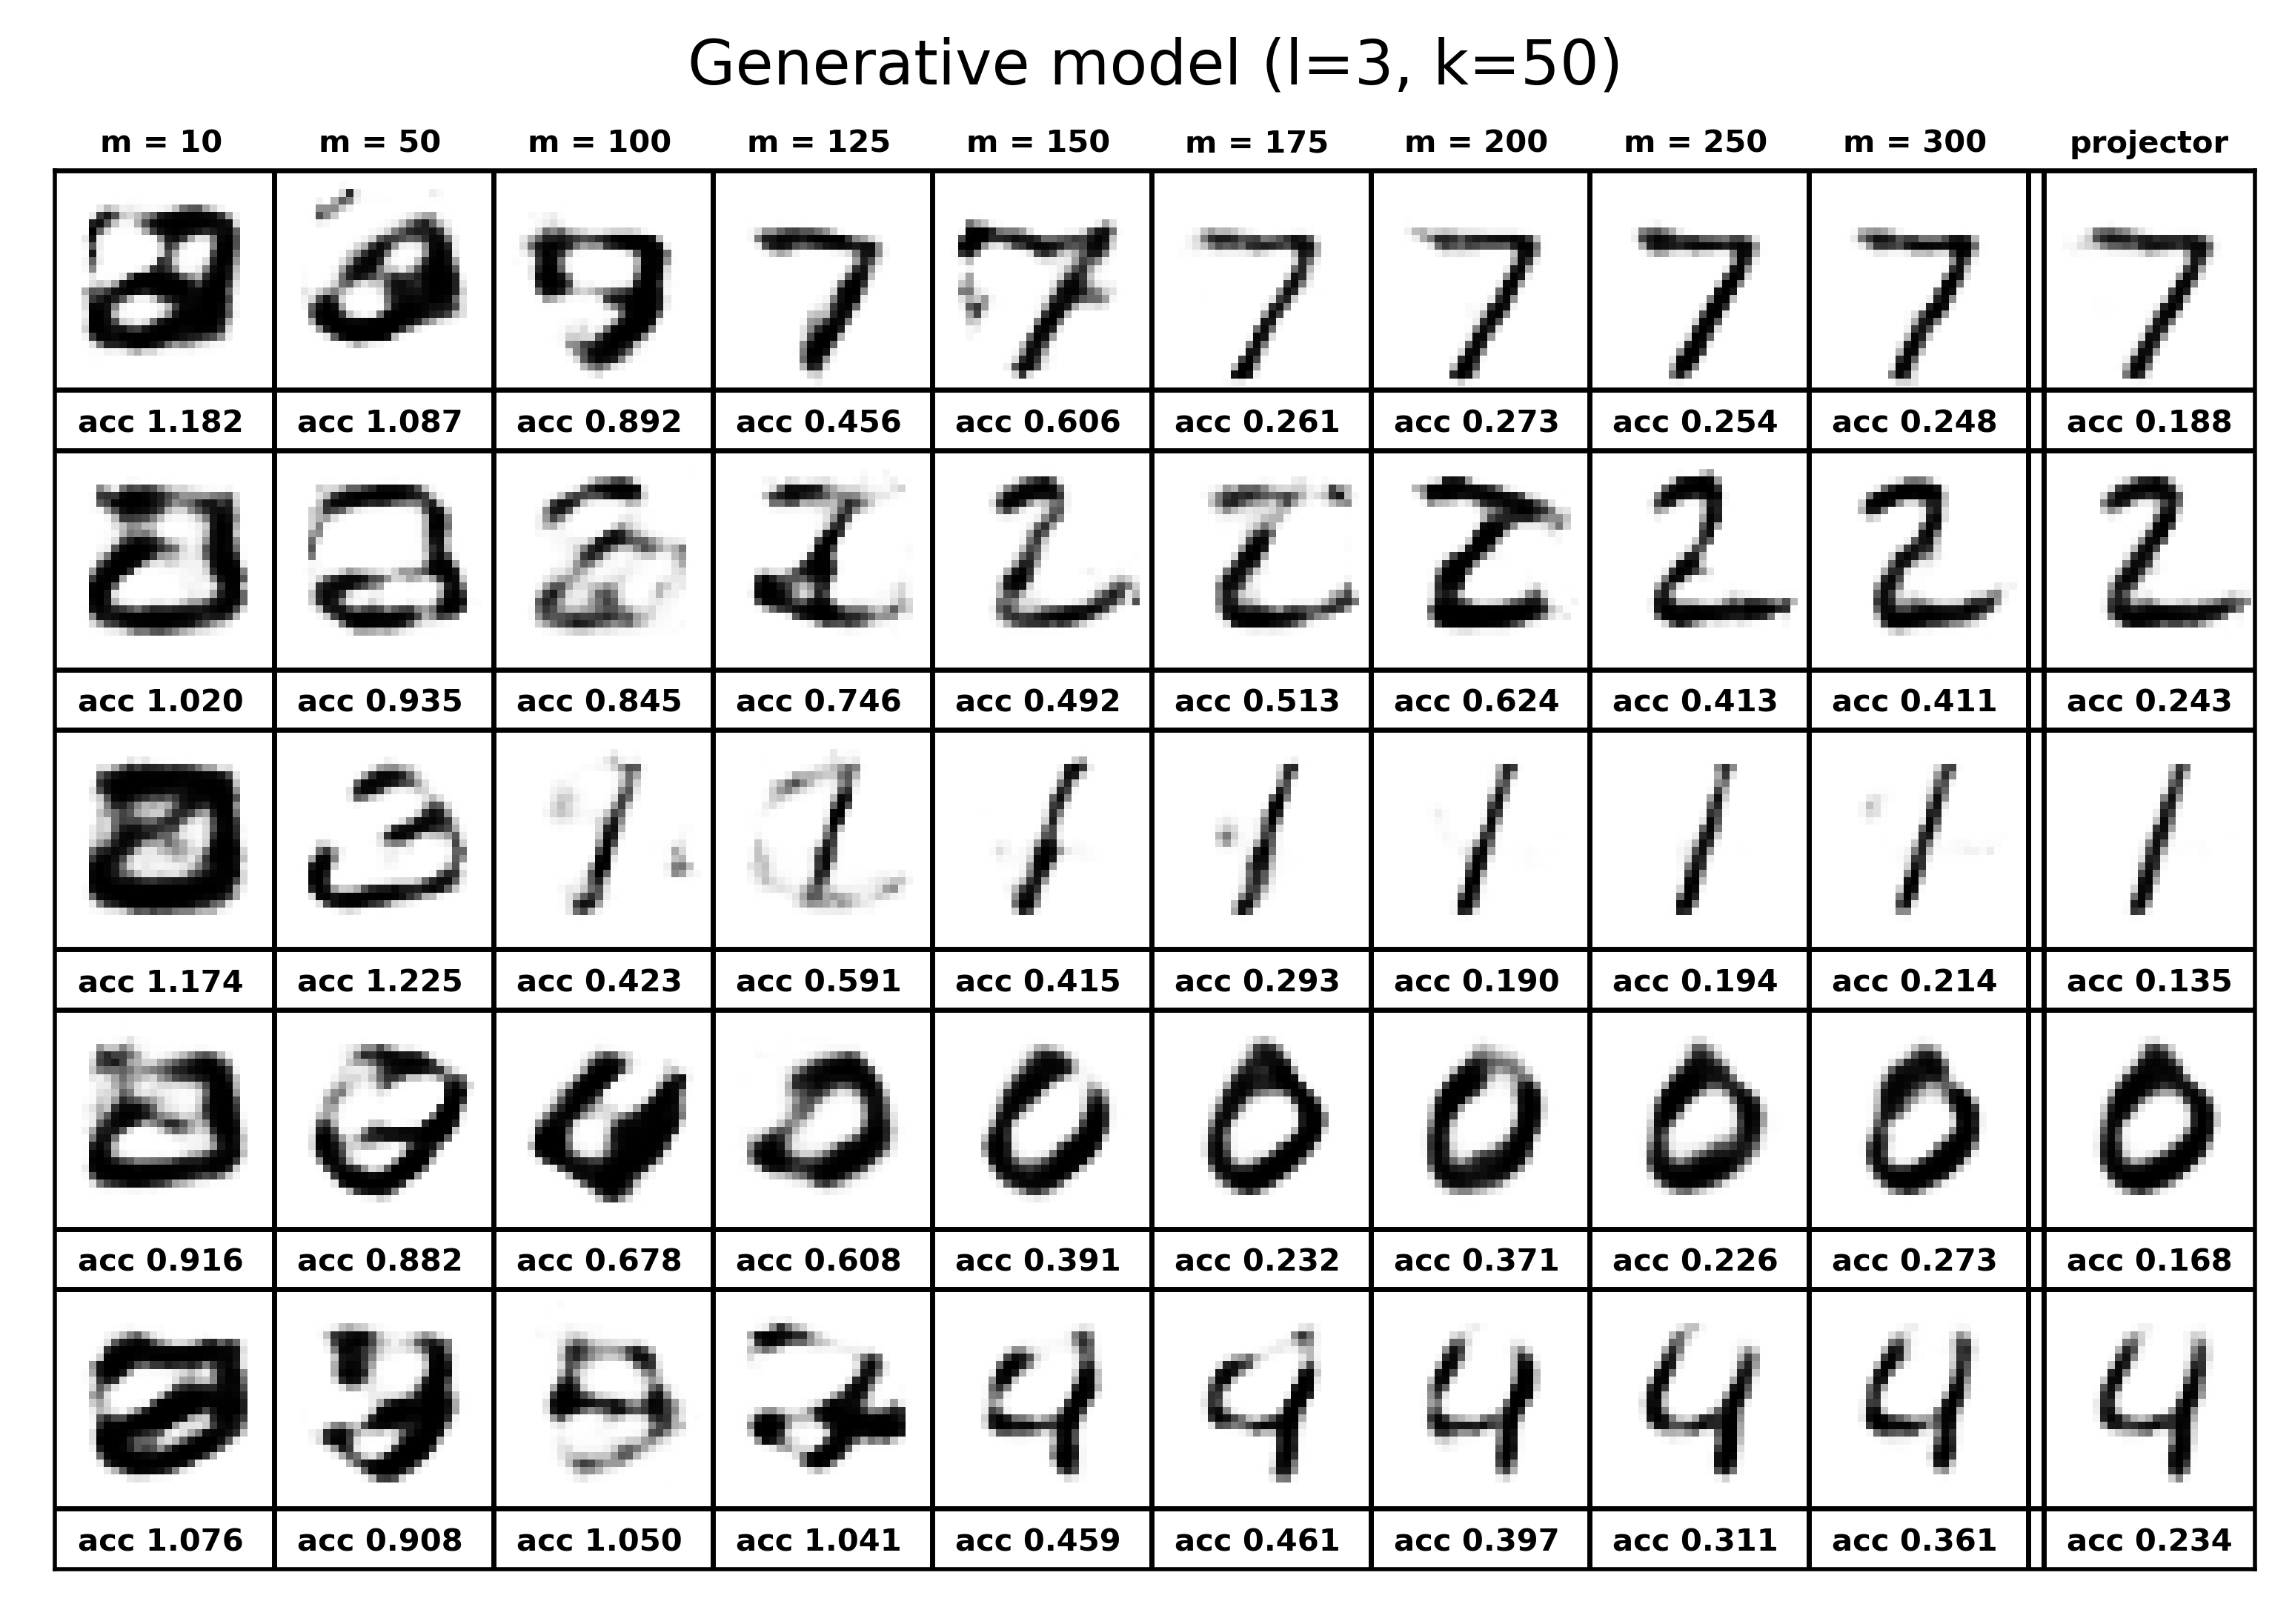

In [28]:
accheight = 8;

results = np.zeros((((28+accheight+1)*5) + 1,(len(mspace_gen)+1)*(28+1)+2));

for j in range(5):
    for i in range(len(mspace_gen)):
        index = i;
        image = data[j][index][0];
        image = np.abs(image);
        image = image/np.max(image);
        results[(28+accheight+1)*j + 1:(28+accheight+1)*j+28 + 1,(28+1)*i + 1:(28+1)*i+28 + 1] = MNIST.VectorToImage(image);
    best_img = bests[j][0];
    results[(28+accheight+1)*j + 1:(28+accheight+1)*j+28 + 1,(28+1)*len(mspace_gen) + 1 + 2:(28+1)*len(mspace_gen)+28 + 1 + 2] = best_img;

figure(figsize=(8, 5), dpi=500)
    
plt.imshow(results, cmap='binary');
plt.xticks([]);
plt.yticks([]);
plt.ylim([((28+accheight+1)*5),0]);
plt.xlim([0, (len(mspace_gen)+1)*(28+1)-1 + 2]);
plt.vlines([i*(28+1) for i in range(1,(len(mspace_gen)+1))],0,((28+accheight+1)*5), colors='black', linewidth=1);
plt.vlines([(len(mspace_gen))*(28+1) + 2],0,((28+accheight+1)*5) , colors='black', linewidth=1);
plt.hlines([i*(28+accheight+1) for i in range(5)],0,(len(mspace_gen)+1)*(28+1) + 2, colors='black', linewidth=1);
plt.hlines([i*(28+accheight+1)-accheight for i in range(1,6)],0,(len(mspace_gen)+1)*(28+1)-1 + 2, colors='black', linewidth=1);

for i in range(len(mspace_gen)):
    plt.text((28+1)*i + 14, -2.5, "m = " + str(mspace_gen[i]), fontsize=6.0, fontweight="bold", ha="center");

plt.text((28+1)*len(mspace_gen) + 14 + 2, -2.5, "projector", fontsize=6.0, fontweight="bold", ha="center");

for j in range(5):
    for i in range(len(mspace_gen)):
        string = "acc {:.3f}".format(data[j][i][1]);
        plt.text((28+1)*i + 14, -2.5 + ((j+1)*(28+1+accheight)), string, fontsize=6.0, fontweight="bold", ha="center");
    best_val = bests[j][1];
    string = "acc {:.3f}".format(best_val);
    plt.text((28+1)*len(mspace_gen) + 14 + 2, -2.5 + ((j+1)*(28+1+accheight)), string, fontsize=6.0, fontweight="bold", ha="center");
        
plt.rcParams['axes.titley'] = 1.04;
plt.title("Generative model (l=3, k=50)");

plt.savefig("results_images/images_generative.png", dpi=500);